In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from N_gram import N_gram_Component
from metrics import run_metrics

data_1 = pd.read_csv("data/BATADAL_dataset03.csv")
data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")
test_data = pd.read_csv("data/BATADAL_test_dataset.csv")

data_1["DATETIME"] = pd.to_datetime(data_1.DATETIME)
data_2["DATETIME"] = pd.to_datetime(data_2.DATETIME)
test_data["DATETIME"] = pd.to_datetime(test_data.DATETIME)

# Selecting a subset of signals
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
       # make test data
import datetime
test_data['ATT_FLAG'] = pd.Series(np.zeros(test_data.shape[0])) # default 0 (no-attack)

# start setting values
attack_times = [
    [pd.Timestamp("2017-01-16T09"), pd.Timestamp("2017-01-19T06")],
    [pd.Timestamp("2017-01-30T08"), pd.Timestamp("2017-02-02T00")],
    [pd.Timestamp("2017-02-09T03"), pd.Timestamp("2017-02-10T09")],
    [pd.Timestamp("2017-02-12T01"), pd.Timestamp("2017-02-13T07")],
    [pd.Timestamp("2017-02-24T05"), pd.Timestamp("2017-02-28T08")],
    [pd.Timestamp("2017-03-10T14"), pd.Timestamp("2017-03-13T21")],
    [pd.Timestamp("2017-03-25T20"), pd.Timestamp("2017-03-27T01")]
]

for times in attack_times:
    indexes = np.where(test_data['DATETIME'].between(times[0], times[1], inclusive=True))[0]
    test_data['ATT_FLAG'][indexes] = 1 # set 1 (attack)

X = data_1[signals].to_numpy()

### Discretization

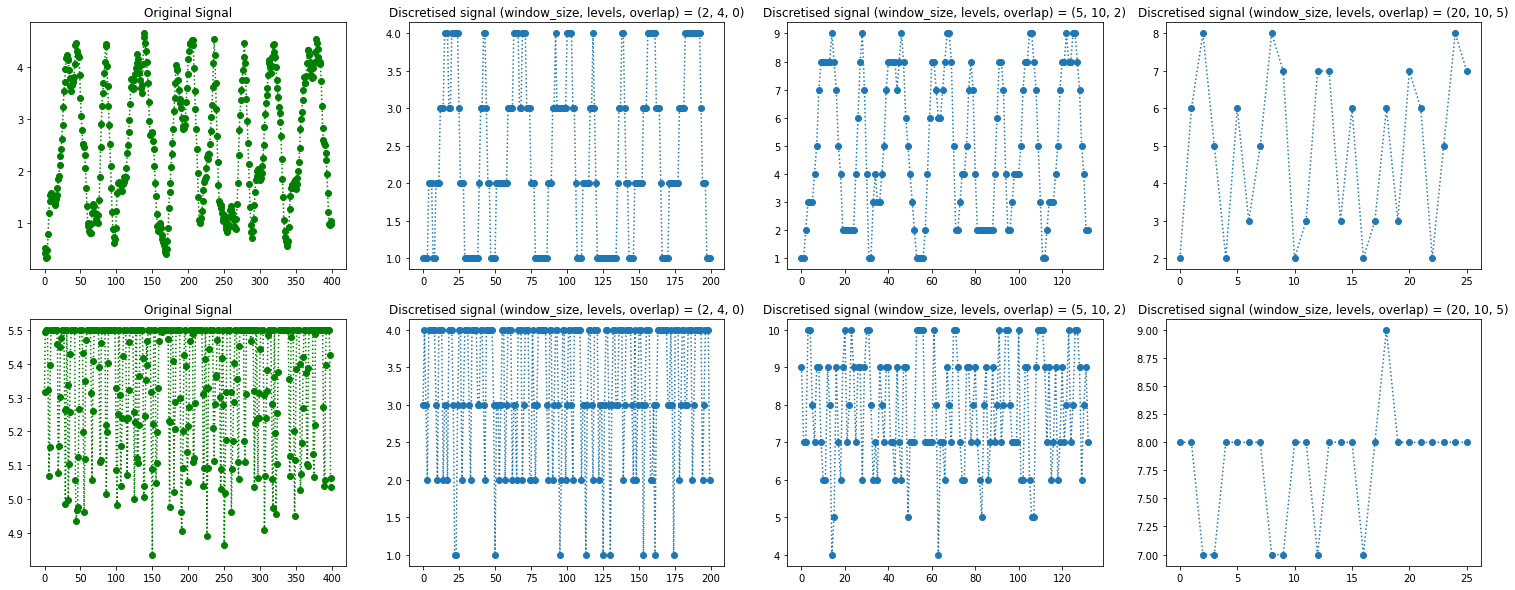

In [17]:
N_gram = N_gram_Component(2, len(signals))

# Plot
# different window_size and overlap
params = np.array([[2, 4, 0], [5, 10, 2], [20, 10, 5]])
fig, axs = plt.subplots(2,4)
fig.set_size_inches((26,10))
x_range = 400
axs[0,0].set_title('Original Signal')
axs[0,0].plot(range(x_range), X[0:x_range, 0], 'o:g')
axs[1,0].set_title('Original Signal')
axs[1,0].plot(range(x_range), X[0:x_range, 5], 'o:g')

for i in range(np.shape(params)[0]):
    X_windowed = N_gram.discretise(X, window_size=params[i,0], levels =params[i,1],  overlap=params[i,2])
    x_range_ = x_range / (params[i,0] - params[i,2])
    axs[0,i+1].set_title('Discretised signal (window_size, levels, overlap) = (' + str(params[i,0])+', '+str(params[i,1])+', '+str(params[i,2])+")")
    axs[0,i+1].plot(range(int(x_range_)), X_windowed[0:int(x_range_), 0], 'o:')
    axs[1,i+1].set_title('Discretised signal (window_size, levels, overlap) = (' + str(params[i,0])+', '+str(params[i,1])+', '+str(params[i,2])+")")
    axs[1,i+1].plot(range(int(x_range_)), X_windowed[0:int(x_range_), 5], 'o:')

plt.show()

Lets select discretization parameters (window_size, levels, overlap) as (5, 10, 2)

### Selct $L$ and $N$ now

In [18]:
# X is dataset_1 and Z is dataset_2
X_labels = np.zeros(np.shape(X)[0])
Z = data_2[signals].to_numpy()
Z_labels = data_2['ATT_FLAG'].to_numpy()
Z_outlier_indexes = list(np.where(Z_labels == 1))[0]
Z_inlier_indexes = list(np.where(Z_labels == -999))[0]

Z_outliers = Z[Z_outlier_indexes, :]
Z_inliers = Z[Z_inlier_indexes, :]
Z_outlier_labels = Z_labels[Z_outlier_indexes]
Z_inlier_labels = np.zeros(len(Z_inlier_indexes))
# Z_outliers_labels = Z_labels[Z_outlier_indexes]
# Z_inliers_labels = Z_labels[Z_inlier_indexes]

# discretization is done only once 
X_windowed = N_gram.discretise(X, window_size=5, levels=10,  overlap=2)
Z_inlier_windowed = N_gram.discretise(Z_inliers, window_size=5, levels=10,  overlap=2)
Z_outlier_windowed = N_gram.discretise(Z_outliers, window_size=5, levels=10,  overlap=2)

print(X_labels)
X_labels = N_gram.discretise_labels(X_labels, window_size=5, overlap=2)
Z_inlier_labels = N_gram.discretise_labels(Z_inlier_labels, window_size=5, overlap=2)
Z_outlier_labels = N_gram.discretise_labels(Z_outlier_labels, window_size=5, overlap=2)
print(Z_inlier_labels)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [19]:
test_X = test_data[signals].to_numpy()
test_X_windowed = N_gram.discretise(test_X, window_size=5, levels=10,  overlap=2)
test_Y = test_data['ATT_FLAG'].to_numpy()
test_Y_windowed = N_gram.discretise_labels(test_Y, window_size=5, overlap=2)
print(test_X.shape)
print(test_Y.shape)

(2089, 43)
(2089,)


In [24]:
from tqdm import tqdm
acc = []
L_arr = [20, 30, 40, 50, 60, 70] # dont have enough outliers to go beyound 70

for L in L_arr:
    acc_ = []
    for N in range(1,5): # only upto 4 due to high processing time
        N_gram = N_gram_Component(N, len(signals))

        X_profiles = N_gram.generate_profiles(X_windowed, L)
        X_profile_labels = N_gram.generate_profile_labels(X_labels, L)

        Z_in_profiles = N_gram.generate_profiles(Z_inlier_windowed, L)
        Z_in_profile_labels = N_gram.generate_profile_labels(Z_inlier_labels, L)

        Z_out_profiles = N_gram.generate_profiles(Z_outlier_windowed, L)
        Z_out_profile_labels = N_gram.generate_profile_labels(Z_outlier_labels, L)

        # print(X_profiles.shape)
        # print(X_profile_labels.shape)
        # print(Z_in_profiles.shape)
        # print(Z_in_profile_labels.shape)
        # print(Z_out_profiles.shape)
        # print(Z_out_profile_labels.shape)
        # Stack train data together for training k-NearestNeighbour

        train_X = np.vstack((Z_in_profiles, Z_out_profiles))
        train_Y = np.vstack((Z_in_profile_labels, Z_out_profile_labels))

        unique, counts = np.unique(train_Y, return_counts=True)
        print(np.asarray((unique, counts)))


        test_X_profiles = N_gram.generate_profiles(test_X_windowed, L)
        test_X_profile_labels = N_gram.generate_profile_labels(test_Y_windowed, L)

        # print(test_X_profiles.shape)
        # print(test_X_profile_labels.shape)

        N_gram.fit_kNN(train_X, train_Y)
        y_pred = N_gram.classify(test_X_profiles, L)
        # print(test_X_profile_labels)
        # print(y_pred)
        # print(y_pred.shape)

        result = run_metrics(test_X_profile_labels, y_pred)
        acc_.append(result['accuracy']) 
        print(str([L,N]) + " done")
    acc.append(acc_)
print("Completed :)")

[[ 0.  1.]
 [65.  3.]]
[20, 1] done
[[ 0.  1.]
 [65.  3.]]
[20, 2] done
[[ 0.  1.]
 [65.  3.]]
[20, 3] done
[[ 0.  1.]
 [65.  3.]]
[20, 4] done
[[ 0.  1.]
 [43.  2.]]
[30, 1] done
[[ 0.  1.]
 [43.  2.]]
[30, 2] done
[[ 0.  1.]
 [43.  2.]]
[30, 3] done
[[ 0.  1.]
 [43.  2.]]
[30, 4] done
[[ 0.  1.]
 [32.  1.]]
[40, 1] done
[[ 0.  1.]
 [32.  1.]]
[40, 2] done
[[ 0.  1.]
 [32.  1.]]
[40, 3] done
[[ 0.  1.]
 [32.  1.]]
[40, 4] done
[[ 0.  1.]
 [26.  1.]]
[50, 1] done
[[ 0.  1.]
 [26.  1.]]
[50, 2] done
[[ 0.  1.]
 [26.  1.]]
[50, 3] done
[[ 0.  1.]
 [26.  1.]]
[50, 4] done
[[ 0.  1.]
 [21.  1.]]
[60, 1] done
[[ 0.  1.]
 [21.  1.]]
[60, 2] done
[[ 0.  1.]
 [21.  1.]]
[60, 3] done
[[ 0.  1.]
 [21.  1.]]
[60, 4] done
[[ 0.  1.]
 [18.  1.]]
[70, 1] done
[[ 0.  1.]
 [18.  1.]]
[70, 2] done
[[ 0.  1.]
 [18.  1.]]
[70, 3] done
[[ 0.  1.]
 [18.  1.]]
[70, 4] done
Completed :)


Text(225.48000000000002, 0.5, 'L')

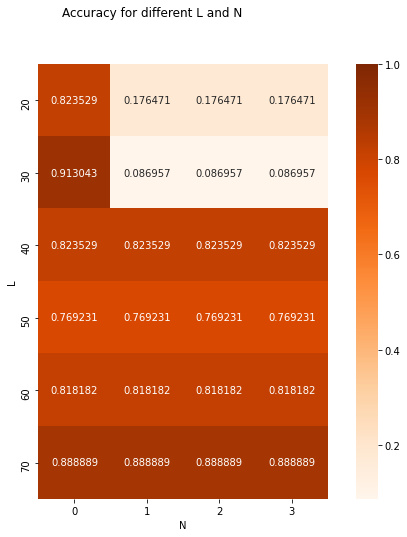

In [25]:
import seaborn as sns
acc = np.array(acc)
fig = plt.figure(figsize=(10,8))
fig.suptitle("Accuracy for different L and N")
sns.heatmap(acc, square=True, annot=True, fmt=".6f", cmap='Oranges', vmax=1, xticklabels=range(0,4), yticklabels=L_arr)
plt.xlabel('N')
plt.ylabel('L')